In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from matplotlib import cm
import numpy as np

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix


from sklearn.naive_bayes import GaussianNB

In [25]:
pd.options.display.max_colwidth = 150

In [34]:
df = pd.read_csv('train.csv')

In [35]:
df.shape

(7613, 5)

In [30]:
df_real_preview = df[df['target'] == 1]
df_fake_preview = df[df['target'] == 0]

In [46]:
df_real_preview.shape
df_fake_preview.shape

(4342, 5)

In [44]:
df_real_preview[df_real_preview['text'].str.contains('shot')]

,id,keyword,location,text,target
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ablaze http://t.co/gWNRhMSO8k,1
1249,1803,buildings%20on%20fire,Peoria,What news reports am I missing? Are there buildings on fire people shot etc. due to videos? #PPSellsBabyParts https://t.co/Wzc5r4XOqZ,1
1713,2470,collided,From a torn up town MANCHESTER,Two cars collided following shotgun fire in Denton http://t.co/0r03C6njLI,1
3112,4466,electrocuted,North Carolina,I'm loving this classic barn shot! We may or may not have got electrocuted got stung a few times and stepped in... http://t.co/X6aSGRjsWC,1
3313,4747,evacuate,Nashville,@ahhtheenikki And from what I can tell- they responded to today's gunman quickly and were able to evacuate all the ppl so no one was shot.,1
3442,4919,exploded,"Chicago, IL",Final #Medinah update: shot a 105. 49 on front (exploded with a) 56 on back. #ImKeepingMyDayJob (pic is famous #17) http://t.co/kcmbBwwp8G,1
3714,5282,fear,Midwestern USA,@CowgirlLawyer We must refuse to become a nation with everyone living in fear of being shot unawares by intoxicated &amp;/or crazy people.,1
4402,6258,hijacking,NaN,Û÷Good SamaritansÛª shot in horror hijacking JOHANNESBURG. &amp;mdash; Four men were shot dead in Bronville Free StateÛ_ http://t.co/6jjvCDN4TI,1
4417,6278,hijacking,Zimbabwe,Û÷Good SamaritansÛª shot in horror hijacking http://t.co/V5yUUALoqw #263Chat #Twimbos ZimpapersViews,1
4807,6843,loud%20bang,English Midlands,St steel coffee cafetiere exploded this am with loud bang hot coffee &amp; grounds shot over table clean crockery phone\ntablet. How?,1


In [33]:
df_fake_preview['text'][300:350]

518                                                   I liked a @YouTube video http://t.co/TNXQuOr1wb Kalle Mattson - 'Avalanche' (Official Video)
519                                                                                                             we'll crash down like an avalanche
520                  #Colorado #Avalanche Men's Official Colorado Avalanche Reebok T-Shirt XL Blue 100% Cotton http://t.co/ZNSvsTGwx3 #NHL #Hockey
521                                         2 TIX 10/3 Frozen Fury XVII: Los Angeles Kings v Avalanche 103 Row:AA MGM Grand http://t.co/kBtZZZG2Tp
522                                                                                   I BET YOU DIDNT KNOW I KICK BOX TOO! https://t.co/rBrw8pWiPJ
523            A little piece I wrote for the Avalanche Designs blog! I'd appreciate it greatly if you checked it out :-)  https://t.co/rfvjh58eF2
524                 PATRICK ROY 1998-99 UPPER DECK SPX #171 FINITE 1620 MADE COLORADO AVALANCHE MINT http://t.co/uHfM1

## Tokenize, Lemmatize, Stop Words

In [3]:
def remove_urls(df):
    df['text'] = df['text'].str.replace(r"http\S+", "")

remove_urls(df)

In [4]:
#creating list of stop words to be removed from body of tweet texts. Punctuation and 
tokenizer = RegexpTokenizer(r'(?u)(?<![@])#?\b\w\w+\b')
sw_list = stopwords.words('english')
sw_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            '-', '–', '—', 'airplane mode', 'co', 'û_','ûï', 'amp', 'get', 'new', 'one', 'go', 'rt', 'gt']
sw_set = set(sw_list)

In [5]:
def process_text(text):
    tokens = tokenizer.tokenize(text)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in sw_set]
    return stopwords_removed

In [6]:
df['text'] = list(map(process_text, df['text']))

In [7]:
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer()

def lemmatize_text(df_text):
    lemmatized_review=[]
    for w in df_text:
        lemmatized_review.append(lemmatizer.lemmatize(w))
    return lemmatized_review

In [8]:
df['text'] = df['text'].apply(lemmatize_text)

In [9]:
all_words = [word for tokens in df['text'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df['text']]
vocab = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(vocab)))
print("Max sentence length is %s" % max(sentence_lengths))

66638 words total, with a vocabulary size of 14197
Max sentence length is 23


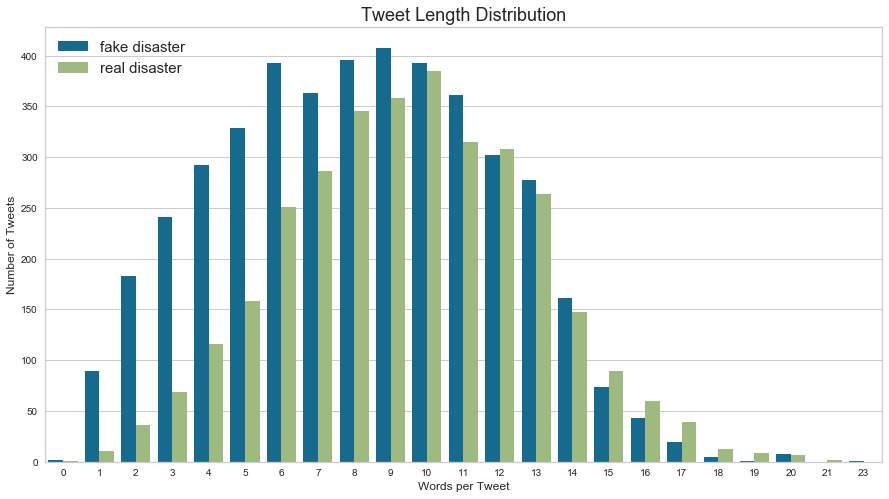

In [10]:
plt.figure(figsize = (15,8))
sns.countplot(sentence_lengths, hue = 'target', data = df)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.legend(['fake disaster','real disaster'], fontsize = 15)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize =12)
plt.show()

In [16]:
#tweet_text_list = df['text'].tolist()

In [23]:
df_real = df[df['target']==1]
df_fake = df[df['target']==0]

In [26]:
df_real['text']

0                                                                                  [deed, reason, #earthquake, may, allah, forgive, u]
1                                                                                        [forest, fire, near, la, ronge, sask, canada]
2                                    [resident, asked, shelter, place, notified, officer, evacuation, shelter, place, order, expected]
3                                                                [13, 000, people, receive, #wildfires, evacuation, order, california]
4                                                                  [got, sent, photo, ruby, #alaska, smoke, #wildfires, pours, school]
                                                                     ...                                                              
7608                                                                      [two, giant, crane, holding, bridge, collapse, nearby, home]
7609                                                   

In [106]:
#df_real['text'] = df_real['text'].apply(lemmatize_text)
#df_fake['text'] = df_fake['text'].apply(lemmatize_text)

In [107]:
df_fake.head(200)

,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0
16,24,NaN,NaN,I love fruits,0
17,25,NaN,NaN,Summer is lovely,0
18,26,NaN,NaN,My car is so fast,0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0
...,...,...,...,...,...
330,477,armageddon,California,Check out #PREPPERS #DOOMSDAY MUST HAVE LIBRAR...,0
332,479,armageddon,NaN,So the Ahamedis think the Messiah had already ...,0
333,480,armageddon,The Orwellion police-state,Sadly How Windows 10 Reveals Microsoft's Ethic...,0
334,481,armageddon,"Castaic, CA",Armageddon averted by El Patron\n#UltimaLucha,0


In [127]:
tweet_real = df_real['text']
tweet_fake = df_fake['text']


In [128]:
tweet_real.tolist()
tweet_fake.tolist()

["What's up man?",
 'I love fruits',
 'Summer is lovely',
 'My car is so fast',
 'What a goooooooaaaaaal!!!!!!',
 'this is ridiculous....',
 'London is cool ;)',
 'Love skiing',
 'What a wonderful day!',
 'LOOOOOOL',
 "No way...I can't eat that shit",
 'Was in NYC last week!',
 'Love my girlfriend',
 'Cooool :)',
 'Do you like pasta?',
 'The end!',
 'We always try to bring the heavy. #metal #RT ',
 'Crying out for more! Set me ablaze',
 'On plus side LOOK AT THE SKY LAST NIGHT IT WAS ABLAZE ',
 "@PhDSquares #mufc they've built so much hype around new acquisitions but I doubt they will set the EPL ablaze this season.",
 'Ablaze for you Lord :D',
 'Check these out:     #nsfw',
 "on the outside you're ablaze and alive\nbut you're dead inside",
 'Had an awesome time visiting the CFC head office the ancop site and ablaze. Thanks to Tita Vida for taking care of us ??',
 'SOOOO PUMPED FOR ABLAZE ???? @southridgelife',
 'I wanted to set Chicago ablaze with my preaching... But not my hotel! ',


In [129]:
processed_real = list(map(process_text, tweet_real))
processed_fake = list(map(process_text, tweet_fake))

In [130]:
all_real_words = [word for tokens in processed_real for word in tokens]
real_sentence_lengths = [len(tokens) for tokens in processed_real]
real_vocab = sorted(list(set(all_real_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_real_words), len(real_vocab)))
print("Max sentence length is %s" % max(real_sentence_lengths))

31008 words total, with a vocabulary size of 8496
Max sentence length is 21


In [131]:
all_fake_words = [word for tokens in processed_fake for word in tokens]
fake_sentence_lengths = [len(tokens) for tokens in processed_fake]
fake_vocab = sorted(list(set(all_fake_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_fake_words), len(fake_vocab)))
print("Max sentence length is %s" % max(fake_sentence_lengths))

35282 words total, with a vocabulary size of 10817
Max sentence length is 23


In [140]:
flat_real = [item for sublist in processed_real for item in sublist]
flat_fake = [item for sublist in processed_fake for item in sublist]

In [141]:
real_freq = FreqDist(flat_real)
fake_freq = FreqDist(flat_fake)

In [142]:
real_freq

FreqDist({'fire': 180, 'via': 121, 'disaster': 113, 'suicide': 112, 'california': 111, 'police': 108, 'people': 104, 'killed': 94, 'storm': 87, 'fires': 85, ...})

In [143]:
fake_freq

FreqDist({'body': 115, 'would': 101, 'via': 99, 'people': 94, 'video': 94, 'love': 87, 'day': 86, 'know': 86, 'time': 84, 'got': 84, ...})

In [144]:
real_freq.most_common(20)

[('fire', 180),
 ('via', 121),
 ('disaster', 113),
 ('suicide', 112),
 ('california', 111),
 ('police', 108),
 ('people', 104),
 ('killed', 94),
 ('storm', 87),
 ('fires', 85),
 ('crash', 83),
 ('news', 83),
 ('families', 81),
 ('train', 79),
 ('bomb', 76),
 ('buildings', 76),
 ('emergency', 74),
 ('two', 74),
 ('attack', 71),
 ('hiroshima', 70)]

In [163]:
fake_frequency = fake_freq.most_common()

In [181]:
fake_freq_col = []
for items in fake_frequency:
    fake_freq_col.append(items[0])

In [183]:
fake_freq_value = []
for items in fake_frequency:
    fake_freq_value.append(items[1])

In [185]:
fake_freq_col
fake_freq_value

[115,
 101,
 99,
 94,
 94,
 87,
 86,
 86,
 84,
 84,
 84,
 84,
 82,
 79,
 76,
 76,
 72,
 72,
 70,
 67]

In [213]:
# create counts of real and fake disaster tweets with values and words

real_bar_counts = [x[1] for x in real_freq.most_common(15)]
real_bar_words = [x[0] for x in real_freq.most_common(15)]

fake_bar_counts = [x[1] for x in fake_freq.most_common(15)]
fake_bar_words = [x[0] for x in fake_freq.most_common(15)]

AttributeError: 'Rectangle' object has no property 'sort'

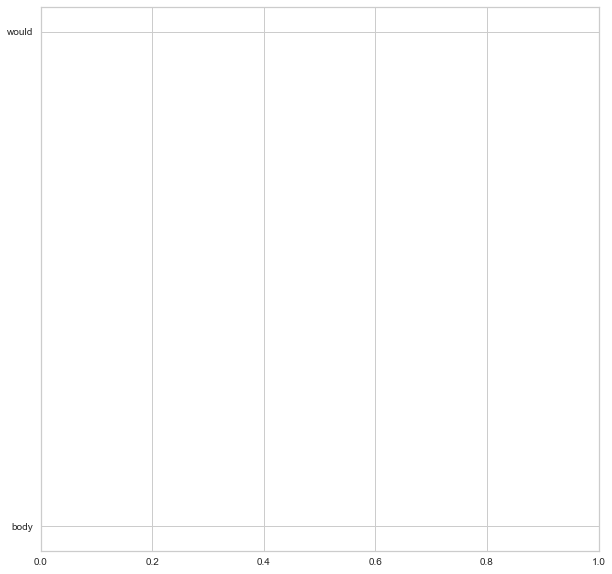

In [209]:
fig = plt.figure(figsize=(10, 10))
plt.barh(fake_freq_col, fake_freq_value, sort = True)
plt.show()

In [199]:
real_bar_words = real_bar_words.reverse()

In [196]:
fake_bar_words.reverse()

In [197]:
fake_bar_words

['world',
 'life',
 'think',
 'man',
 'good',
 'want',
 'fire',
 'gt',
 'still',
 'us',
 'let',
 'going',
 'emergency',
 'see',
 'back',
 'full',
 'got',
 'time',
 'know',
 'day',
 'love',
 'video',
 'people',
 'would',
 'body']

In [302]:
color_real = cm.inferno(np.linspace(.6,.7, 20))
color_fake = cm.cividis(np.linspace(.1,.4, 30))

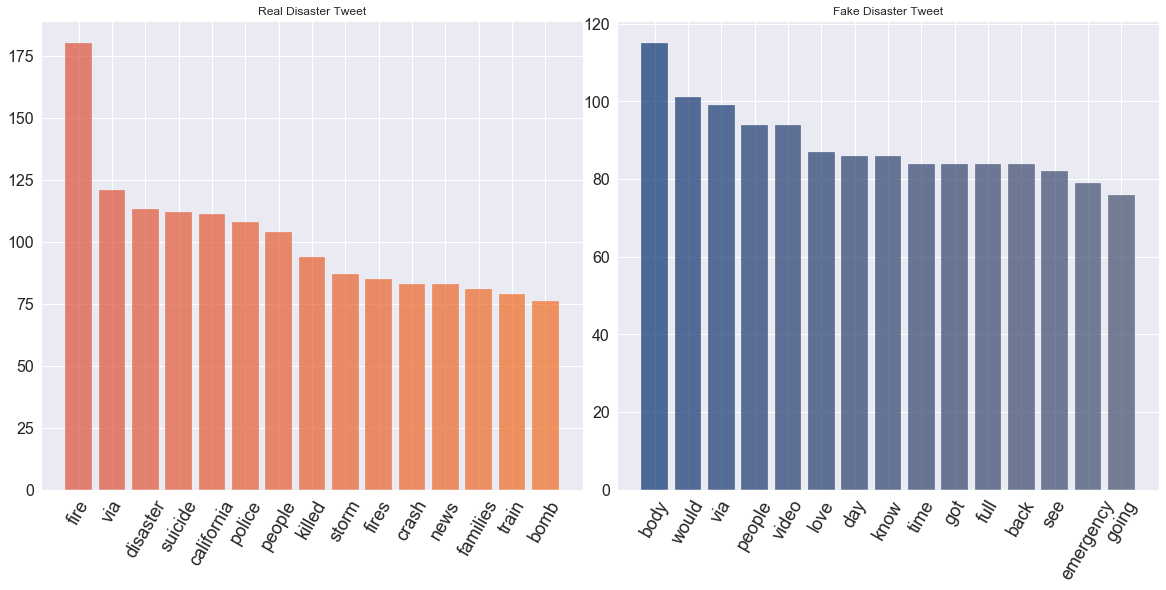

In [303]:
sns.set_style('darkgrid')
new_figure = plt.figure(figsize=(16,8))

ax = new_figure.add_subplot(121)
ax2 = new_figure.add_subplot(122)

# Generate a line plot on first axes
ax.bar((real_bar_words), real_bar_counts, color=color_real, align='center', alpha=0.7)
# ax.plot(colormap='PRGn')

# Draw a scatter plot on 2nd axes
ax2.bar(fake_bar_words, fake_bar_counts, color=color_fake, align='center', alpha=0.7)

ax.title.set_text('Real Disaster Tweet')
ax2.title.set_text('Fake Disaster Tweet')

for ax in new_figure.axes:
    plt.sca(ax)
    plt.xticks(rotation=60, fontsize = 18)
    plt.yticks(fontsize = 16)
plt.tight_layout(pad=0)

# plt.savefig('word count bar graphs.png')

plt.show()


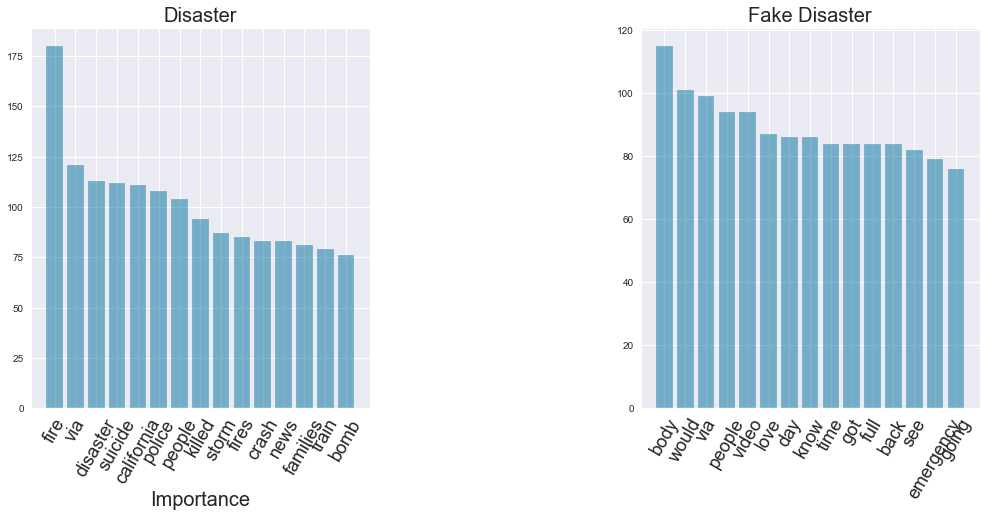

In [267]:
fig = plt.figure(figsize=(17, 7))  

plt.subplot(121)
plt.bar(real_bar_words, real_bar_counts, align='center', alpha=0.5)
plt.title('Disaster', fontsize=20)
#plt.yticks(real_bar_words, fontsize=18)
plt.xlabel('Importance', fontsize=20)
plt.xticks(rotation = 60, fontsize = 18)


plt.subplot(122)
plt.bar(fake_bar_words, fake_bar_counts, align='center', alpha=0.5)
plt.title('Fake Disaster', fontsize=20)
plt.xticks(rotation = 60, fontsize=18)
#plt.xlabel('Importance', fontsize=20)
plt.subplots_adjust(wspace=0.8)
plt.show()

## Modeling

In [11]:
df['text'] = df['text'].apply(lemmatize_text)

In [12]:
tweet_list = df['text'].tolist()

In [13]:
joined_tweets = [] 
for words in tweet_list: 
    superlist = ' '.join(x for x in words)
    joined_tweets.append(superlist)
    

In [14]:
y = df['target']
X = joined_tweets

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [321]:
from sklearn.feature_extraction.text import CountVectorizer


vec = CountVectorizer(stop_words=None)
X_train_vec = vec.fit_transform(X_train)
X_test_vec = vec.transform(X_test)

In [323]:
X_vec_train = X_train_vec.toarray()
X_vec_test = X_test_vec.toarray()

In [16]:

tfidf = TfidfVectorizer()

tfidf_data_train = tfidf.fit_transform(X_train)
tfidf_data_test = tfidf.transform(X_test)

tfidf_data_train

<6090x11907 sparse matrix of type '<class 'numpy.float64'>'
	with 51689 stored elements in Compressed Sparse Row format>

## Naive Bayes 

In [318]:
tf_train = tfidf_data_train.toarray()
tf_test = tfidf_data_test.toarray()

In [324]:
gnb = GaussianNB()

In [326]:
gnb.fit(X_vec_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [327]:
gnb.score(X_vec_test, y_test)

0.6080105055810899

## SVM

In [329]:
from sklearn import svm

In [331]:
clf = svm.SVC()
clf.fit(tfidf_data_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [334]:
S_V = clf.predict(tfidf_data_test)

In [335]:
print(classification_report(y_test, S_V))

              precision    recall  f1-score   support

           0       0.58      1.00      0.73       882
           1       0.00      0.00      0.00       641

    accuracy                           0.58      1523
   macro avg       0.29      0.50      0.37      1523
weighted avg       0.34      0.58      0.42      1523



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest 

In [17]:
RF = RandomForestClassifier(n_estimators=100, random_state=0)

In [18]:
forest = RF.fit(tfidf_data_train, y_train)

RF_predict = RF.predict(tfidf_data_test)

In [19]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, RF_predict)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('\nAUC is :{0}'.format(round(roc_auc, 2)))



AUC is :0.76


/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


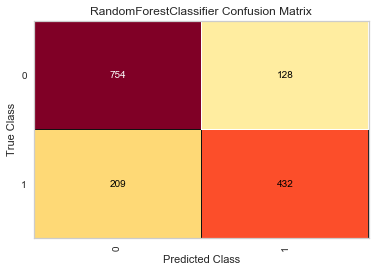

In [20]:

cm = ConfusionMatrix(forest)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model

cm.score(tfidf_data_test, y_test)


cm.show()

In [21]:
print(classification_report(y_test, RF_predict))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       882
           1       0.77      0.67      0.72       641

    accuracy                           0.78      1523
   macro avg       0.78      0.76      0.77      1523
weighted avg       0.78      0.78      0.78      1523

